## Malaria Cell Classification: Parasitized or Uninfected?


# Introduction:

The goal of this project is to build a Convolutional Neural Network to correctly identify if whether or not a Malaria cell is Parasitized. The model will take in a picture of said malaria cell and calculate the probability that said malaria cell is parasitized or uninfected

## Installing Libraries

Most Libraries used for this project are already pre installed in the Kaggle kernel environment

In [1]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


## Importing Necessary Libraries

The following packages run the models:

In [2]:
# Core
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import glob
import random
import os
import cv2
#tesor fow & keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense,BatchNormalization,Dropout,Input
from keras.models import Sequential, Model
from keras.layers import Conv2D,GlobalMaxPooling2D
from tensorflow.keras.applications import  Xception,VGG16,InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
#cnn
from tensorflow.keras import datasets, layers, models

from keras.layers import Input, Conv2D, MaxPool2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation, MaxPooling2D
from keras.engine.base_layer import Layer
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, f1_score, recall_score, precision_score
import splitfolders

In [3]:
!ls ../input/cell-images-for-detecting-malaria/cell_images

Parasitized  Uninfected  cell_images


# 1. EXPLORE THE DATASET TO UNDERSTAND ITS CHARACTERISTICS

## Data Exploration
### Raw Comparison
### Visualizing a few randomly sampled images of Parasitized and Uninfected cell Images

I'll begin by first accessing the main directory and listing its contents:

In [4]:
data_directory = os.listdir('../input/cell-images-for-detecting-malaria/cell_images')
print(data_directory)

['Uninfected', 'Parasitized', 'cell_images']


There seems to be an issue with duplicating the 'cell_images' folder so i will be ignoring it

Next, I'll print the contents of each sub directory and the number of files each folder contains.

In [5]:
main_dir = '../input/cell-images-for-detecting-malaria/cell_images'

In [6]:
x_parasitized = len(os.listdir(main_dir  + '/Parasitized'))
x_uninfected= len(os.listdir(main_dir  + '/Uninfected'))
print('Data: , Parasitized Images: {}, Uninfected Images: {}, Total: {}'.format( x_parasitized,
                                                                            x_uninfected, (x_parasitized + x_uninfected)))

Data: , Parasitized Images: 13780, Uninfected Images: 13780, Total: 27560


## Dividing data into training testing and validation

In [7]:
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio("../input/cell-images-for-detecting-malaria/cell_images/", output="output",
    seed=1337, ratio=(.7, .2,.1), group_prefix=None, move=False)

Copying files: 27560 files [03:07, 147.10 files/s]


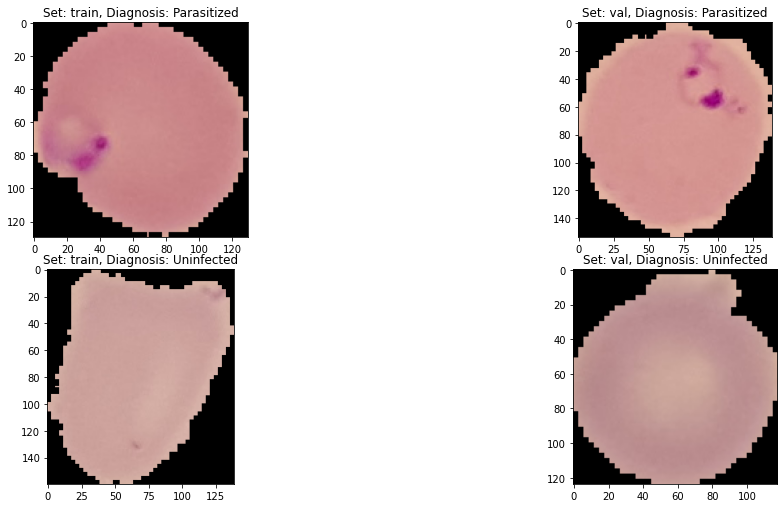

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

new_dir = "./output/"
for i, _set in enumerate(['train', 'val']):
    set_path = new_dir+_set
    ax[i].imshow(plt.imread(set_path+'/Parasitized/'+os.listdir(set_path+'/Parasitized/')[1]), cmap='gist_gray')
    ax[i].set_title('Set: {}, Diagnosis: Parasitized'.format(_set))
    ax[i+2].imshow(plt.imread(set_path+'/Uninfected/'+os.listdir(set_path+'/Uninfected/')[1]), cmap='gist_gray')
    ax[i+2].set_title('Set: {}, Diagnosis: Uninfected'.format(_set))

## Average Image
### Finding the average image for each class. To compute the average image, we can take the average value of each pixel across all observations
#### for speed I used 2000 images for each class

(1000, 128, 128, 3)
(128, 128, 3)


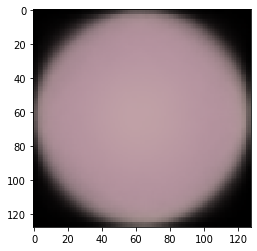

In [9]:
from PIL import Image
from numpy import *
from pylab import *
import glob
from matplotlib import pyplot as plt

imlist = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/Uninfected/*.png')
im = array(Image.open(imlist[0])) # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images
# create matrix to store all flattened images
immatrix = array([array(Image.open(im).resize((128,128),Image.BICUBIC))
              for im in imlist[:1000]])
print(immatrix.shape)

imave = average(immatrix,axis=0)
print(imave.shape)
result = Image.fromarray(imave.astype('uint8'))
plt.imshow(result, interpolation='nearest')
plt.show()

../input/cell-images-for-detecting-malaria/cell_images/Parasitized/C99P60ThinF_IMG_20150918_141001_cell_93.png 13779
(1000, 128, 128, 3)
(128, 128, 3)


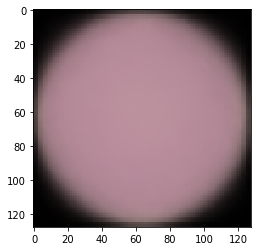

In [10]:
imlist = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/Parasitized/*.png')
im = array(Image.open(imlist[0])) # open one image to get size
m,n = im.shape[0:2] # get the size of the images
imnbr = len(imlist) # get the number of images
print(imlist[0],len(imlist))
# create matrix to store all flattened images
immatrix = array([array(Image.open(im).resize((128,128),Image.BICUBIC))
              for im in imlist[:1000]])
print(immatrix.shape)

imave = average(immatrix,axis=0)
print(imave.shape)
result = Image.fromarray(imave.astype('uint8'))
plt.imshow(result, interpolation='nearest')
plt.show()

## Checking Data Balance:

In [11]:
new_dir =  './output/'
train_dir = os.path.join(new_dir, "train")
test_dir = os.path.join(new_dir, "test")
val_dir = os.path.join(new_dir, "val")

In [12]:
#Train data:
train_df = []

parasitized_set = os.path.join(train_dir,'Parasitized')
uninfected_set = os.path.join(train_dir,'Uninfected')

#Image list:

parasitized_images = glob.glob(parasitized_set+"/*.jpg") + glob.glob(parasitized_set+"/*.jpeg") + glob.glob(parasitized_set+"/*.png")
uninfected_images = glob.glob(uninfected_set + "/*.jpg") + glob.glob(uninfected_set + "/*.jpeg") + glob.glob(uninfected_set + "/*.png")

#parasitized_images scans are labeled 0:
for img in parasitized_images:
    train_df.append((img, 1))

#uninfected_images are labeled 1:
for img in uninfected_images:
    train_df.append((img, 0))

#Creating a dataframe:
train_df = pd.DataFrame(train_df, columns=['Image', 'Diagnosis'], index=None)

In [13]:
#Train data:
test_df = []

parasitized_set = os.path.join(test_dir,'Parasitized')
uninfected_set = os.path.join(test_dir,'Uninfected')

#Image list:

parasitized_images = glob.glob(parasitized_set+"/*.jpg") + glob.glob(parasitized_set+"/*.jpeg") + glob.glob(parasitized_set+"/*.png")
uninfected_images = glob.glob(uninfected_set + "/*.jpg") + glob.glob(uninfected_set + "/*.jpeg") + glob.glob(uninfected_set + "/*.png")

#Benign scans are labeled 0:
for img in parasitized_images:
    test_df.append((img, 1))

#Malignant are labeled 1:
for img in uninfected_images:
    test_df.append((img, 0))

#Creating a dataframe:
test_df = pd.DataFrame(test_df, columns=['Image', 'Diagnosis'], index=None)

In [14]:
test_df.head()

,Image,Diagnosis
0,./output/test/Parasitized/C154P115ThinF_IMG_20...,1
1,./output/test/Parasitized/C51AP12thinF_IMG_201...,1
2,./output/test/Parasitized/C118P79ThinF_IMG_201...,1
3,./output/test/Parasitized/C37BP2_thinF_IMG_201...,1
4,./output/test/Parasitized/C51AP12thinF_IMG_201...,1


In [15]:
def balance_check(data):
#'data': the dfs we've created
    image_count = data['Diagnosis'].value_counts()
    print('Counts:')
    print(image_count)
    
    plt.figure(figsize=(11,7))
    sns.barplot(x= image_count.index, y= image_count.values)
    plt.title('Plot of Diagnosis Balancing', fontsize= 14)
    plt.xlabel('Diagnosis', fontsize= 11)
    plt.ylabel('Image Count', fontsize= 11)
    plt.xticks(range(len(image_count.index)), ['Uninfected(0)', 'Parasitized(1)'])
    plt.show()

Counts:
1    9645
0    9645
Name: Diagnosis, dtype: int64


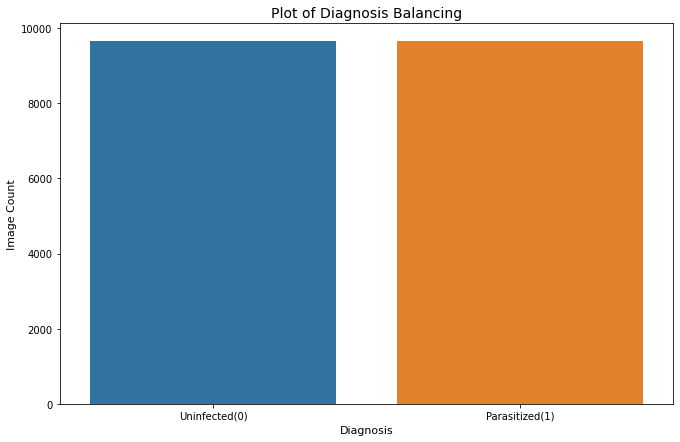

In [16]:
balance_check(train_df)

Counts:
1    1378
0    1378
Name: Diagnosis, dtype: int64


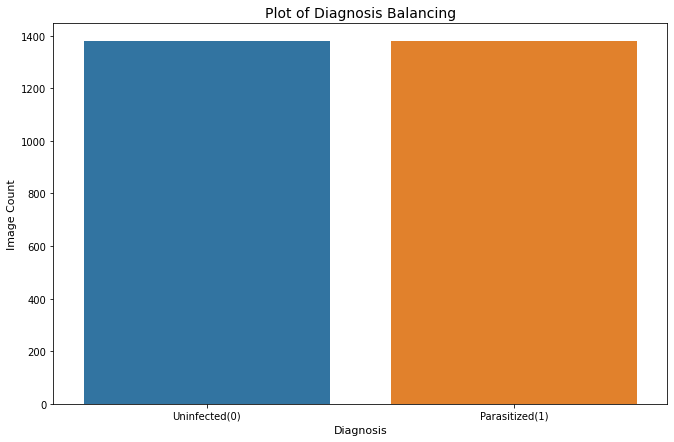

In [17]:
balance_check(test_df)

### Model Visualization Function:

Now I'll define a function that plots the accuracy and loss results of my CNN models for easy interpretation:

In [18]:
def model_performance(history, name):
    
    history_dict = history.history
    train_loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']#<--'val' here is for validation, and will be from the 'test' dataset
    train_accuracy = history_dict['accuracy']
    val_accuracy = history_dict['val_accuracy']

    fig, axis = plt.subplots(ncols=1, nrows=2, figsize=(8,8))
    
    #Plotting loss results:    
    epochs = range(1, len(val_loss_values) + 1) #epoch: the number of times the model will be fit on the training set.
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=train_loss_values, label='Train Loss')
    plot1 = sns.lineplot(ax=axis[0], x=epochs, y=val_loss_values, label='Val Loss')
    plot1.set(xlabel='Epochs', ylabel='Loss')
    plot1.axes.set_title(f'{name} Loss', fontsize=18)
    plot1.grid(b=True, which='major', axis='y') #To show the grid lines or not
    
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=train_accuracy, label='Train Accuracy')
    plot2 = sns.lineplot(ax=axis[1], x=epochs, y=val_accuracy, label='Val Accuracy')
    plot2.set(xlabel='Epochs', ylabel='Accuracy')
    plot2.axes.set_title(f'{name} Accuracy', fontsize=20)
    plot2.grid(b=True, which='major', axis='y')
    
    plt.tight_layout()
    plt.show()

In [19]:
img_height = 128
img_width = 128
batch_size = 32

# 2. Pre-Processing Data to Make Suitable for Modelling
- data Loading into training testing and validation
- data augumentation
- data scaling and resizing

In [20]:
!ls ./output/train/

Parasitized  Uninfected  cell_images


In [21]:
# !rm -rf ./output/train/cell_images
# !rm -rf ./output/val/cell_images
# !rm -rf ./output/test/cell_images

In [22]:
train_data_dir = './output/train'
val_data_dir = './output/val'
test_data_dir = './output/test'

In [23]:
train_datagen = ImageDataGenerator(
        rescale=1. / 255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        width_shift_range = 0.30,
        height_shift_range = 0.30,
        rotation_range = 20
)
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [24]:
train = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Uninfected', 'Parasitized']
)
test = test_datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Uninfected', 'Parasitized'],
    shuffle=False
)

val = test_datagen.flow_from_directory(
        val_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary',
        classes=['Uninfected', 'Parasitized'],
    shuffle=False
)



Found 19290 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [25]:
# In order to plot the Confusion Matrix, I will be making predictions off of the test set in one batch size
test_data = []
test_labels = []

for cond in ['/Uninfected/', '/Parasitized/']:
    for img in (os.listdir(new_dir + 'test' + cond)):
        img = plt.imread(new_dir+'test'+cond+img)
        img = cv2.resize(img, (img_height, img_height))
        img = np.dstack([img, img, img])
        img = img.astype('float32') / 255
        if cond=='/Uninfected/':
            label = 0
        elif cond=='/Parasitized/':
            label = 1
        test_data.append(img)
        test_labels.append(label)

test_data = np.array(test_data)
test_labels = np.array(test_labels)

In [26]:
labels = (train.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'Uninfected', 1: 'Parasitized'}

# 3. Building Models for Malaria cell detection of parasites

## Model 1 - SIMPLE CNN

In [27]:
model1 = Sequential([
    
    Conv2D(filters=8,kernel_size=(3,3), activation='relu',input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=8,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=16,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

2022-04-19 10:09:11.970615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:09:12.063574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:09:12.064406: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 10:09:12.066266: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 16)        0

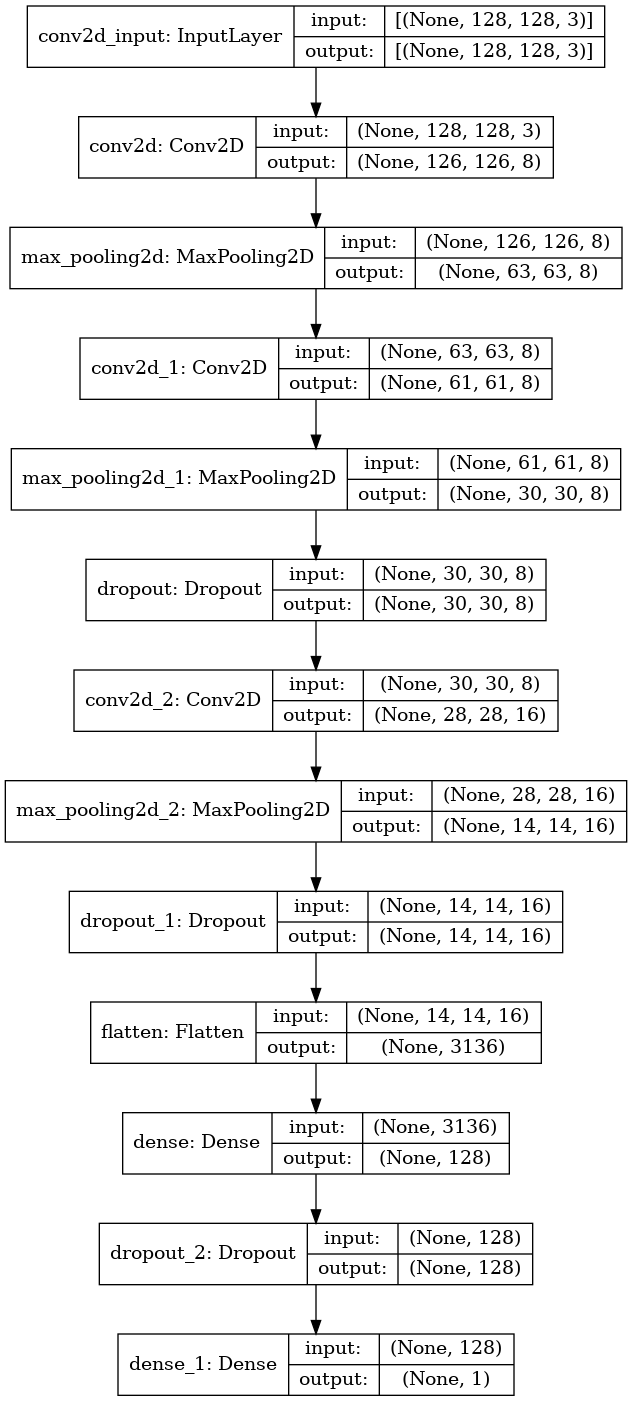

In [30]:
tf.keras.utils.plot_model(
    model1,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [31]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
#hdf5 (Hierarchical Data Format) is to store the weights of the best performing epoch
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max') #<--Reduce learning rate 
#when the metric has stopped improving.
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

In [32]:
epochs = 15
hist1 = model1.fit(train, steps_per_epoch=train.samples // batch_size, 
           epochs=epochs, validation_data=val, shuffle=True,
           validation_steps=val.samples // batch_size, callbacks=[checkpoint, lr_reduce])

2022-04-19 10:09:19.949577: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-04-19 10:09:21.504639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


602/602 [==============================] - 107s 167ms/step - loss: 0.5531 - accuracy: 0.7179 - val_loss: 0.2847 - val_accuracy: 0.9086
Epoch 2/15
602/602 [==============================] - 96s 159ms/step - loss: 0.3368 - accuracy: 0.8769 - val_loss: 0.2059 - val_accuracy: 0.9291
Epoch 3/15
602/602 [==============================] - 96s 160ms/step - loss: 0.3123 - accuracy: 0.8861 - val_loss: 0.1962 - val_accuracy: 0.9310

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
602/602 [==============================] - 97s 161ms/step - loss: 0.2957 - accuracy: 0.8892 - val_loss: 0.1775 - val_accuracy: 0.9368
Epoch 5/15
602/602 [==============================] - 98s 162ms/step - loss: 0.2944 - accuracy: 0.8899 - val_loss: 0.1827 - val_accuracy: 0.9297

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/15
602/602 [==============================] - 99s 165ms/step - loss: 0.2845 - accuracy: 0.8924 - val_loss: 0.1775 -

# Model2 VGG-16
- Training a VGG-16 model from scratch

In [33]:
model2 = keras.models.Sequential()
model2.add(keras.applications.VGG16(include_top=False, pooling='max', weights='imagenet'))
model2.add(Dense(1, activation='sigmoid'))

model2.layers[0].trainable = True

model2.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

58900480/58889256 [==============================] - 0s 0us/step


In [34]:
epochs = 15
hist2 = model2.fit(train, steps_per_epoch=train.samples // batch_size, 
           epochs=epochs, validation_data=val, shuffle=True,
           validation_steps=val.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
602/602 [==============================] - 124s 201ms/step - loss: 0.7232 - accuracy: 0.5033 - val_loss: 0.6975 - val_accuracy: 0.4015
Epoch 2/15
602/602 [==============================] - 119s 198ms/step - loss: 0.6878 - accuracy: 0.5136 - val_loss: 0.6940 - val_accuracy: 0.4993
Epoch 3/15
602/602 [==============================] - 115s 190ms/step - loss: 0.6951 - accuracy: 0.4978 - val_loss: 0.6949 - val_accuracy: 0.5007

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
602/602 [==============================] - 116s 192ms/step - loss: 0.6933 - accuracy: 0.5050 - val_loss: 0.6949 - val_accuracy: 0.5007
Epoch 5/15
602/602 [==============================] - 118s 195ms/step - loss: 0.6939 - accuracy: 0.4945 - val_loss: 0.6949 - val_accuracy: 0.5007

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/15
602/602 [==============================] - 118s 196ms/step - loss: 0.6934 - accuracy: 0.4980 - va

# Model3 VGG-19
- Finetuning a VGG-19 Architecture¶

In [35]:
baseModel = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(img_height, img_width, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.25)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model3 = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable = False
    
model3.compile(loss="binary_crossentropy", optimizer='adam',
    metrics=["accuracy"])

80150528/80134624 [==============================] - 0s 0us/step


In [36]:
epochs = 15
hist3 = model3.fit(train, steps_per_epoch=train.samples // batch_size, 
           epochs=epochs, validation_data=val, shuffle=True,
           validation_steps=val.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
602/602 [==============================] - 108s 178ms/step - loss: 0.4565 - accuracy: 0.8022 - val_loss: 0.3397 - val_accuracy: 0.8376
Epoch 2/15
602/602 [==============================] - 112s 186ms/step - loss: 0.3656 - accuracy: 0.8425 - val_loss: 0.2806 - val_accuracy: 0.8801
Epoch 3/15
602/602 [==============================] - 107s 178ms/step - loss: 0.3422 - accuracy: 0.8552 - val_loss: 0.3623 - val_accuracy: 0.8281
Epoch 4/15
602/602 [==============================] - 112s 186ms/step - loss: 0.3396 - accuracy: 0.8556 - val_loss: 0.2988 - val_accuracy: 0.8692
Epoch 5/15
602/602 [==============================] - 112s 186ms/step - loss: 0.3323 - accuracy: 0.8589 - val_loss: 0.2928 - val_accuracy: 0.8723

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 6/15
602/602 [==============================] - 108s 179ms/step - loss: 0.3121 - accuracy: 0.8734 - val_loss: 0.2321 - val_accuracy: 0.9062
Epoch 7/15
602/602 [=======================

In [37]:
model4 = tf.keras.models.Sequential()
model4.add(keras.applications.ResNet50(include_top=False, pooling='max', weights='imagenet'))
model4.add(Dense(1, activation='sigmoid'))
# ResNet-50 model is already trained, should not be trained
model4.layers[0].trainable = True

model4.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

94781440/94765736 [==============================] - 0s 0us/step


In [38]:
epochs = 15
hist = model4.fit(train, steps_per_epoch=train.samples // batch_size, 
           epochs=epochs, validation_data=val, shuffle=True,
           validation_steps=val.samples // batch_size, callbacks=[checkpoint, lr_reduce])

Epoch 1/15
602/602 [==============================] - 121s 193ms/step - loss: 0.7140 - accuracy: 0.8333 - val_loss: 0.9891 - val_accuracy: 0.5007
Epoch 2/15
602/602 [==============================] - 121s 201ms/step - loss: 0.4497 - accuracy: 0.8846 - val_loss: 0.1848 - val_accuracy: 0.9379
Epoch 3/15
602/602 [==============================] - 122s 202ms/step - loss: 0.2822 - accuracy: 0.8989 - val_loss: 0.6910 - val_accuracy: 0.7037

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/15
602/602 [==============================] - 115s 191ms/step - loss: 0.2421 - accuracy: 0.9136 - val_loss: 0.1372 - val_accuracy: 0.9553
Epoch 5/15
602/602 [==============================] - 123s 204ms/step - loss: 0.2238 - accuracy: 0.9170 - val_loss: 0.1636 - val_accuracy: 0.9528

Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
Epoch 6/15
602/602 [==============================] - 125s 207ms/step - loss: 0.2101 - accuracy: 0.9229 - va

### Training curves for the four models

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


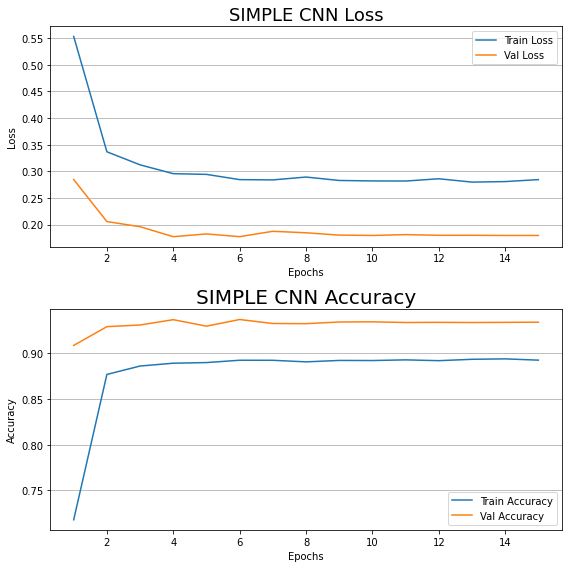

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


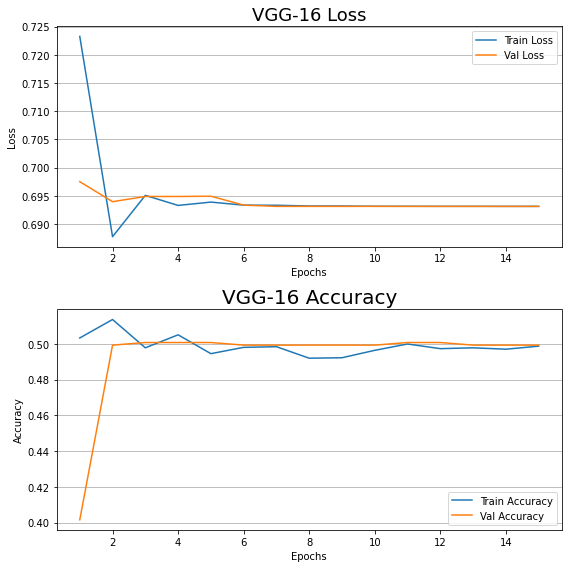

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


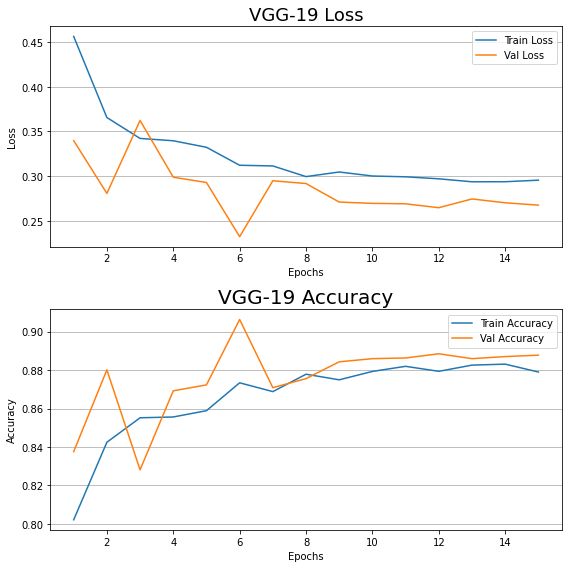

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.


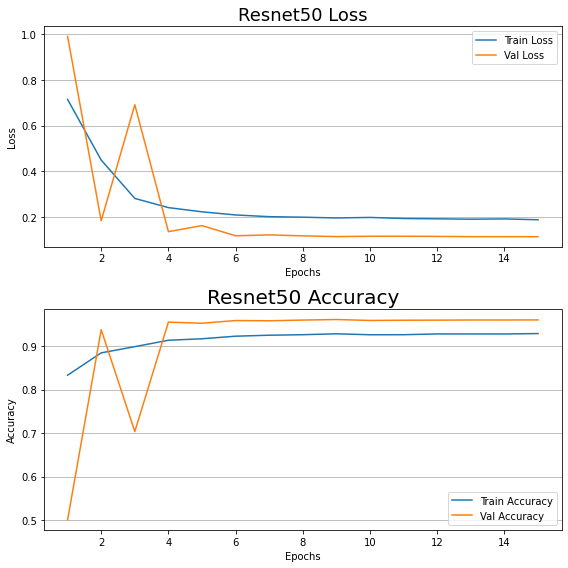

In [39]:
model_performance(hist1, name='SIMPLE CNN')
model_performance(hist2, name='VGG-16')
model_performance(hist3, name='VGG-19')
model_performance(hist, name='Resnet50')

# 4. Model Evaluation and 6. Visualization of metrics
- confusion matricx
- accuracy
- f1 metric
- precision
- recall
- roc auc score
- pr curve

In [40]:
data = {'Ojaswi': {'Age': 15, 'Address': 'Hyderabad'},
        'Rohith':  {'Age': 9, 'Address': 'Hyderabad'},
        'Gnanesh':  {'Age': 15, 'Address': 'Guntur'}}

In [41]:
from sklearn.metrics import precision_recall_curve
def evaluate(model,name):
    preds = model.predict(test)

    accur = accuracy_score(test_labels, np.round(preds))*100
    cm = confusion_matrix(test_labels, np.round(preds))
    tn, fp, fn, tp = cm.ravel()
    #tp = true positive tn = true negative fp = false positive fn = false negative

    labels = ["Uninfected", "Parasitized"]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)



    print('CONFUSION MATRIX ------------------')
    # print(cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    print(f'{name} Model Performance METRICS ----------------------')
    print('\nTEST METRICS ----------------------')
    precision = tp/(tp+fp)*100
    recall = tp/(tp+fn)*100
    print('Accuracy: {}%'.format(accur))
    print('Precision: {}%'.format(precision))
    print('Recall: {}%'.format(recall))
    print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

    print('\nTRAIN METRIC ----------------------')
    print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))
    
    fpr, tpr, _ = roc_curve(test_labels, np.round(preds))
    auc = roc_auc_score(test_labels, np.round(preds))

    #create ROC curve
    plt.subplot(2, 1, 2)
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()
    
    pr, re, thresholds = precision_recall_curve(test_labels, np.round(preds))

    #create precision recall curve
    plt.subplot(1, 2, 2)
    plt.plot(re, pr, color='purple')

    #add axis labels to plot
    plt.title('Precision-Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')

    #display plot
    plt.show()
    
    model_metric = {f'{name}_SCORES':{'Accuracy':accur,'Precision':precision,'Recall':recall,'F1-score':2*precision*recall/(precision+recall),'AUC':auc}}
                    
                    
    return model_metric

CONFUSION MATRIX ------------------


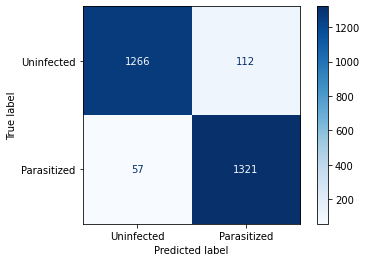

SIMPLE CNN Model Performance METRICS ----------------------

TEST METRICS ----------------------
Accuracy: 93.86792452830188%
Precision: 92.18422889043964%
Recall: 95.86357039187227%
F1-score: 93.98790466026324

TRAIN METRIC ----------------------
Train Accuracy: 92.9


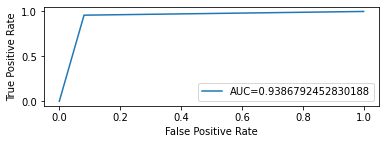

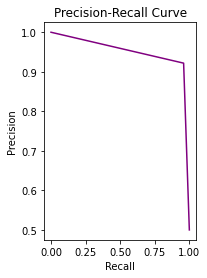

In [42]:
metric1 = evaluate(model1,'SIMPLE CNN')

CONFUSION MATRIX ------------------


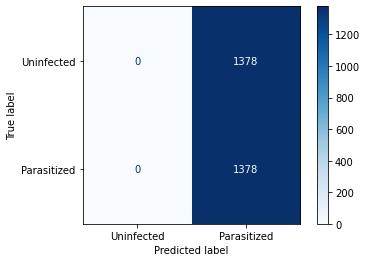

VGG-16 Model Performance METRICS ----------------------

TEST METRICS ----------------------
Accuracy: 50.0%
Precision: 50.0%
Recall: 100.0%
F1-score: 66.66666666666667

TRAIN METRIC ----------------------
Train Accuracy: 92.9


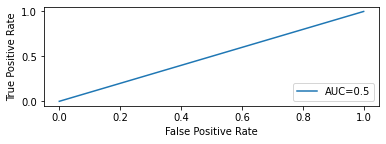

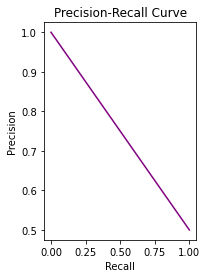

In [43]:
metric2 = evaluate(model2,'VGG-16')


CONFUSION MATRIX ------------------


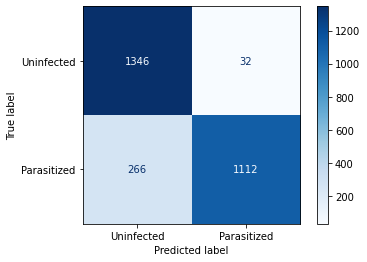

VGG-19 Model Performance METRICS ----------------------

TEST METRICS ----------------------
Accuracy: 89.18722786647315%
Precision: 97.2027972027972%
Recall: 80.6966618287373%
F1-score: 88.18398096748614

TRAIN METRIC ----------------------
Train Accuracy: 92.9


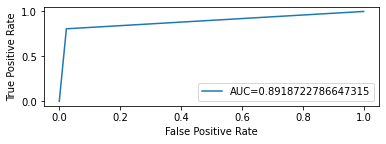

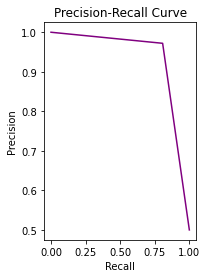

In [44]:
metric3 = evaluate(model3,'VGG-19')

CONFUSION MATRIX ------------------


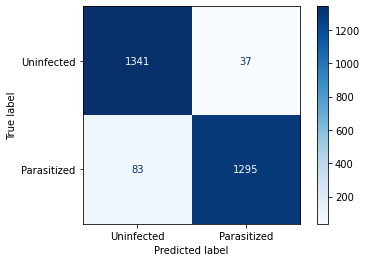

Resnet50 Model Performance METRICS ----------------------

TEST METRICS ----------------------
Accuracy: 95.64586357039188%
Precision: 97.22222222222221%
Recall: 93.9767779390421%
F1-score: 95.5719557195572

TRAIN METRIC ----------------------
Train Accuracy: 92.9


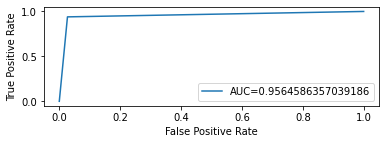

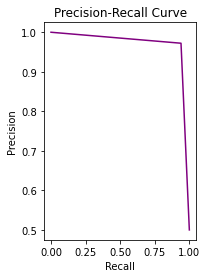

In [45]:
metric4 = evaluate(model4,'Resnet50')

## Comparing the models metrics

In [46]:
metric2

{'VGG-16_SCORES': {'Accuracy': 50.0,
  'Precision': 50.0,
  'Recall': 100.0,
  'F1-score': 66.66666666666667,
  'AUC': 0.5}}

In [47]:
metrics = {**metric1,**metric2, **metric3, **metric4}
metric_df = pd.DataFrame.from_dict(metrics)

In [48]:
metrics

{'SIMPLE CNN_SCORES': {'Accuracy': 93.86792452830188,
  'Precision': 92.18422889043964,
  'Recall': 95.86357039187227,
  'F1-score': 93.98790466026324,
  'AUC': 0.9386792452830188},
 'VGG-16_SCORES': {'Accuracy': 50.0,
  'Precision': 50.0,
  'Recall': 100.0,
  'F1-score': 66.66666666666667,
  'AUC': 0.5},
 'VGG-19_SCORES': {'Accuracy': 89.18722786647315,
  'Precision': 97.2027972027972,
  'Recall': 80.6966618287373,
  'F1-score': 88.18398096748614,
  'AUC': 0.8918722786647315},
 'Resnet50_SCORES': {'Accuracy': 95.64586357039188,
  'Precision': 97.22222222222221,
  'Recall': 93.9767779390421,
  'F1-score': 95.5719557195572,
  'AUC': 0.9564586357039186}}

In [49]:
metric_df.T.head()

,Accuracy,Precision,Recall,F1-score,AUC
SIMPLE CNN_SCORES,93.867925,92.184229,95.863570,93.987905,0.938679
VGG-16_SCORES,50.000000,50.000000,100.000000,66.666667,0.500000
VGG-19_SCORES,89.187228,97.202797,80.696662,88.183981,0.891872
Resnet50_SCORES,95.645864,97.222222,93.976778,95.571956,0.956459


In [50]:
# metric_df = metric_df.T
# metrics_df['AUC'] = metrics_df['AUC']*100

<AxesSubplot:>

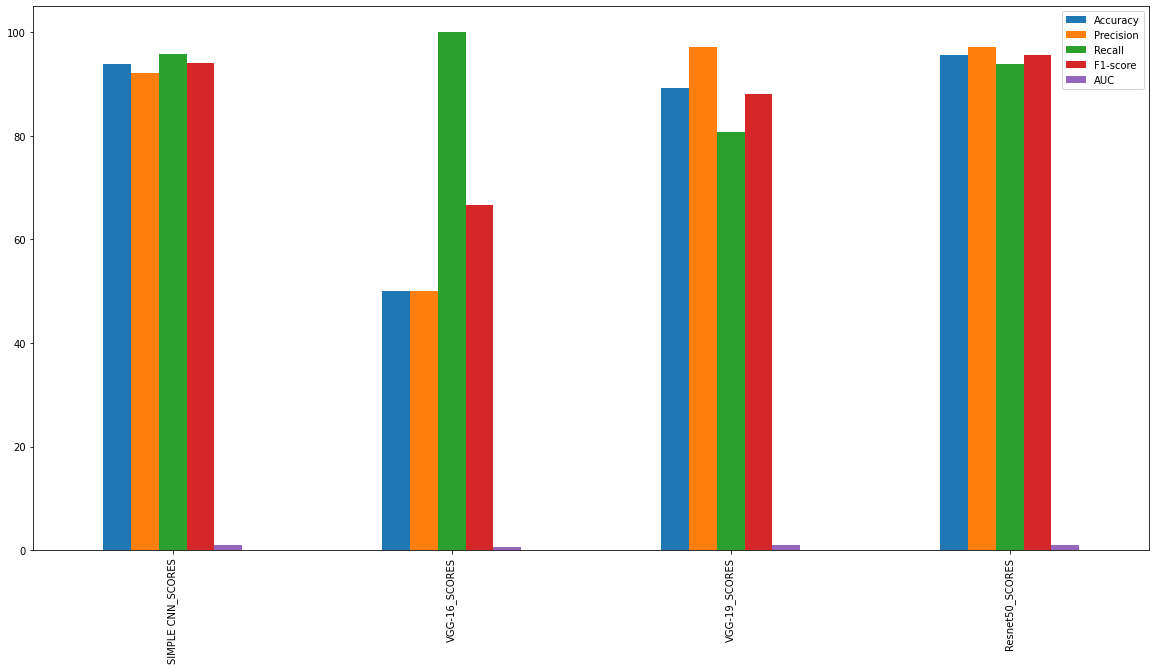

In [51]:
metric_df.T.plot(kind="bar", figsize=(20,10))

# 5. Finetuning best model

# Ensembling
#### using the averaging technique of two models

In [52]:
prediction1 = [item for sublist in model1.predict(test).tolist()[:] for item in sublist]
prediction2 = [item for sublist in model2.predict(test).tolist()[:] for item in sublist]
prediction3 = [item for sublist in model3.predict(test).tolist()[:] for item in sublist]
prediction4 = [item for sublist in model4.predict(test).tolist()[:] for item in sublist]

CONFUSION MATRIX ------------------


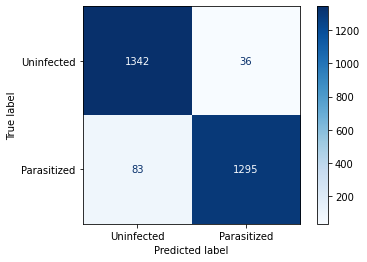

Ensembled Model Performance METRICS ----------------------

TEST METRICS ----------------------
Accuracy: 95.68214804063861%
Precision: 97.29526671675433%
Recall: 93.9767779390421%
F1-score: 95.60723514211885

TRAIN METRIC ----------------------
Train Accuracy: 92.9


In [53]:
ensemble_prediction = [(g*0.2 + h*0.4 + i*0.1 +j*0.3) for g, h, i, j in zip(prediction1,prediction2,prediction3,prediction4)]

accur = accuracy_score(test_labels, np.round(ensemble_prediction))*100
cm = confusion_matrix(test_labels, np.round(ensemble_prediction))
tn, fp, fn, tp = cm.ravel()
#tp = true positive tn = true negative fp = false positive fn = false negative

labels = ["Uninfected", "Parasitized"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)



print('CONFUSION MATRIX ------------------')
# print(cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

print('Ensembled Model Performance METRICS ----------------------')
print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(accur))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train Accuracy: {}'.format(np.round((hist.history["accuracy"][-1])*100, 2)))

In [54]:
preds

NameError: name 'preds' is not defined

In [ ]:
files=test.filenames
class_dict=test.class_indices # a dictionary of the form class name: class index
rev_dict={}
for key, value in class_dict.items():
    
    rev_dict[value]=key   # dictionary

In [ ]:
rev_dict

In [ ]:
import PIL
dir_ = "../input/cell-images-for-detecting-malaria/cell_images/"
for i, p in enumerate(preds[random.randint(0,100)]):
    index=int(np.where(p>=0.5,1,0))
    klass=rev_dict[index]    
    img = PIL.Image.open(dir_+files[i])
    plt.imshow(img)
    print('for file ', files[i], ' predicted class is ', klass)